# Fastai Course Part I Notes

# Steps to Train a Model (fastai image classification)

The purpose of this section is to help you understand at the highest level what training a model to perform a task really means. 

We will go through an example with the case of image classification using the [MNIST dataset][1].

[1]:[http://yann.lecun.com/exdb/mnist/]

In [0]:
# Directives
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# Imports
from fastai.vision import *

## 1. Create `DataBunch`

> Create a `DataBunch` object (in the case of image classification it will be a `ImageDataBunch`).


### Additional Notes

* **Train, Test and Validation Datasets:** The training dataset is used to teach your model based on the labels. The validation dataset is used to make sure you are not overfitting and check how well you have trained using the training dataset. Finally, the test dataset is the final test that you run to double check the results you got with your validation dataset.

* `ImageDataBunch.from_x` where x can be csv, dataframe, folder, lists and more. It is useful to be able to load data that is labeled in these common ways.

* `normalize(imagenet_stats)` is important to call on images to make sure they don't have a specific color channel (RGB) that is higher or lower than the others (ie normalize -> mean = 0; stdev = 1)

* `np.random.seed(2)` Setting this random seed will make sure that if you use a percentage of your training data as a validation set that you choose the *same validation dataset each time*.

In [0]:
np.random.seed(2)

path = untar_data(URLs.MNIST_SAMPLE)

data = ImageDataBunch.from_folder(path)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (12396 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /root/.fastai/data/mnist_sample;

Valid: LabelList (2038 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /root/.fastai/data/mnist_sample;

Test: None

## 2. Create Learner (and define model architecture)

> Create a learner (cnn_learner, rnn_learner, etc) and feed it your data and your model/architecture. Also tell it what metrics you want to print out as it learns.

### Additional Notes

* **Models/Architectures**: ResnetX (where X is the number of layers) is a pre-trained model that has been trained using a dataset called imagenet.

* **Metrics**: The metrics like error rate is *calculated in relation to the validation* set to show you how well you model is doing with images where it doesn't get to look at the labels.

* `learner.save()` is a useful function that saves the model in its current state (ie, all the current weights are saved). It defaults to saving in a subdirectory called models. This is really useful because if you overfit or run a test and mess things up your weights, you can revert back to your previously saved model.

* `learner.load()` loads a previously saved model so that if you broke something you can go back to a previous state.

In [0]:
learner = cnn_learner(data, models.resnet18, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 80631117.14it/s]


## 3. Train Learner & Interpret Results (Repeat as Needed)

### Run First Training Cycle

```python
learner.fit_one_cycle(4, 3e-3)
```

By default this will add some layers to the end of the pre-trained model you loaded before (ie. transfer learning). Train for 4 epochs with a max learning rate of 3e-3.

> **WELL-FIT:** `train_loss` < `valid_loss` (but both should be close)

*Note: You never want a model where your training loss is higher than your validation loss. That means you have not fitted enough (either your LR is too low or epochs too few or both).*

> **OVER-FIT:** error_rate gets better than worse

*Note: People will tell you that if your tr_loss is lower than your validation loss then you are over fitting but NO NO NO that is not true. The error rate which is based on the validation set is your real indication of overfitting.*

### Inspect Results

```python
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

```

You can use the interpretation class to look at the results in more detail.

*Note: Use Kaggle competitions and academic papers to check how well your model is performing compared to others.*

### Fine-tune to get Better Results

```python
learner.unfreeze()
learner.fit_one_cycle(4, slice(X, 3e-4))
```

Where `X` is the steepest part of the most prominent slope of the `learner.lr_find()` plot minus about 10x.

Calling `unfreeze()` will unfreeze the whole model so you can train the whole thing and fine-tune it a bit more. In doing so however its important to use a range of learning rates with a much smaller learning rate in the beginning of the model and a bit higher at the final layers. But still as a general rule use about 10x lower than the first max_lr you used in the firce training cycle.

### Repeat as Needed

Again, plot top losses, checkout the confusion matrix, look at train_loss vs valid_loss graphically.

### Additional Notes

* **LR too HIGH:** valid_loss will be really high (normally should be < 1)

* **LR too LOW:** error_rate gets better but it will be happening really slowly *(Tip: use learner.recorder.plot_losses() to see how the tr_loss, vald_loss gradually go down together).*

* **NUM EPOCHS too LOW:** looks similar to LR too low. If tr_loss and valid_loss are far apart consider running more cycles.

* `learner.fit_one_cycle()` has replaced `fit()` as the new state of the art (faster and more accurate). It starts by shooting the learning rate up then gradually decreasing it.

* `learner.lr_find()` is a tool that tells you how fast you can train the model without. After you unfreeze and plot lr to fine-tune, you can On the lr finder you are going to have to find the strongest downward slope (not little bumps) and pick the steepest part of it then choose about 10x small slice(steepest, 3e-4)

* `learner.recorder.plot_lr()` see how the learning rate changes over time.

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


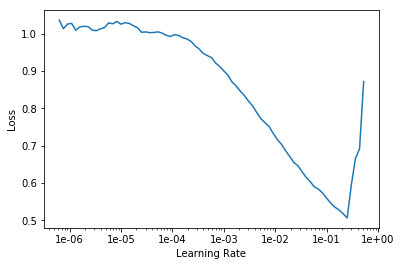

In [0]:
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.127503,0.041506,0.014230,0.985770,01:32
1,0.033828,0.024769,0.006379,0.993621,01:33
2,0.016513,0.013148,0.004907,0.995093,01:33
3,0.010246,0.011010,0.003925,0.996075,01:33


In [0]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

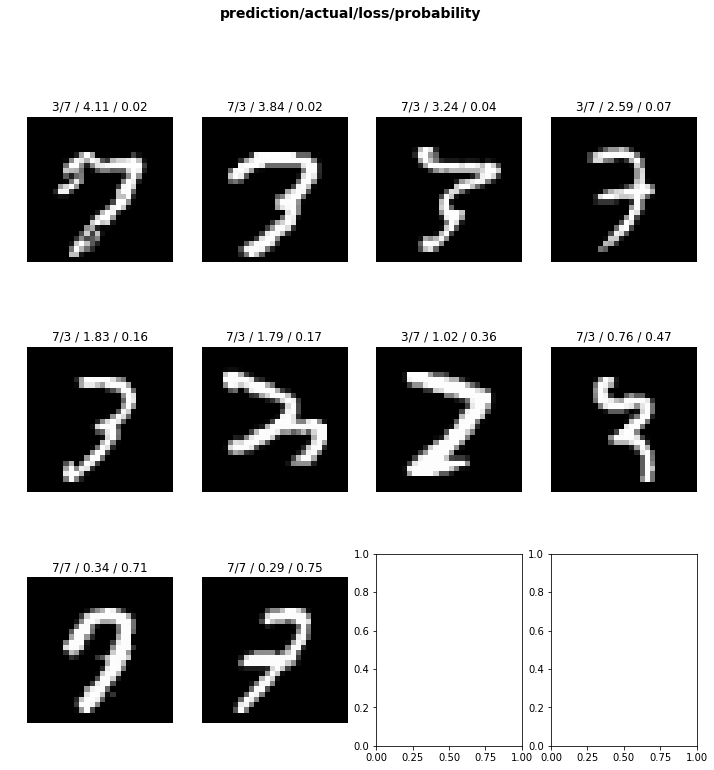

In [0]:
interp.plot_top_losses(10)

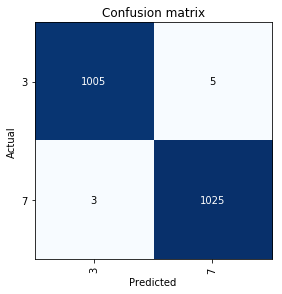

In [0]:
interp.plot_confusion_matrix()

In [0]:
interp.most_confused()

[('3', '7', 5), ('7', '3', 3)]

In [0]:
learner.unfreeze()

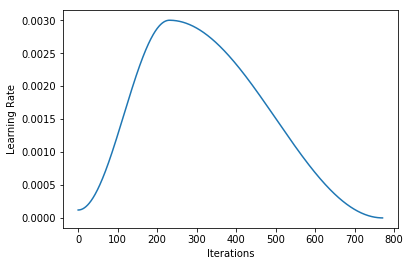

In [0]:
learner.recorder.plot_lr()

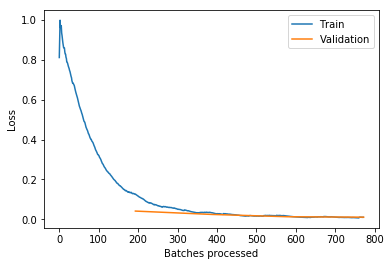

In [0]:
learner.recorder.plot_losses()

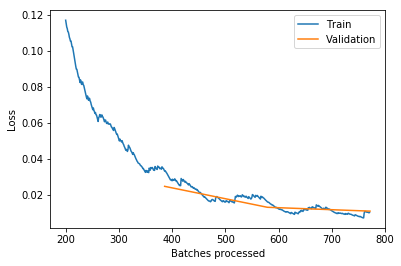

In [0]:
learner.recorder.plot_losses(200)

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


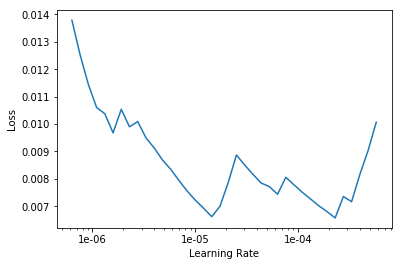

In [0]:
learner.recorder.plot()

In [0]:
learning_rate_finder_strongest_slope = 1e-6
learner.fit_one_cycle(4, slice(learning_rate_finder_strongest_slope, 3e-4)) # the previous lr -10x

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.008559,0.009393,0.003435,0.996565,02:56
1,0.003772,0.009799,0.002944,0.997056,02:58
2,0.004605,0.011059,0.003435,0.996565,03:00
3,0.004098,0.009588,0.003925,0.996075,03:01


We see that our model got better and then started to overfit a bit (error rate got worse). So, we'd probably want to learner.save() the model back before it started getting worse. Checkout the results again try training some more, expirimenting with different learning rates, maybe try a resnet with more layers (ie resnet34 or resnet50), etc.

# Deep Dives & Examples

The purpose of this section is to help you understand in more detail different types of models, how and when they are used, more vocabulary and best practice, and more.

## Deep Dive: Single and Multi-Class Image Classification (fastai.vision)

## Deep Dive: Image Segmentation (fastai.vision)

## Deep Dive: Production / Inference

There are several ways to put a trained model into production but here I will just show you how to save the model for export or use in production then leave getting it into production to you.

#### Create 'export.pkl' 

It will be created in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

```python
learn.export()
```

#### Run predict

This will allow you to call `predict(my_img)` on a new image (`my_img`).

```python
learn = load_learner(path)
pred_class,pred_idx,outputs = learn.predict(my_img)
```


**Additional Notes**

* **CPU or GPU for PROD?** Generally, you will want to use CPU for inference (predicting with a trained model)

* `defaults.device = torch.device('cpu')` if you want to try running on CPU instead of GPU for testing

In [0]:
# classes = []
# data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)
# learner = create_cnn(data2, models.resnet34)

# pred_class, pred_idx, outputs = learner.predict(img)

## Deep Dive: Stochastic Gradient Descent (SGD) w/ PyTorch

Understanding SGD is a fundamental component of understanding deep learning because it is a simple example of a **cost function**.

> **Objectives:** Implement SGD and undestand 
> 1. How to start with a guess and get to a best result by calculating error (using a cost function - SGD in this case) and its gradient to help us determine if our guess is getting better or worse.
> 2. How **learning rate** is analogous to step size

**Formal Problem Statement:** Find the coefficents a and b (they are called parameters in PyTorch) of the line equation such that it best fits the points.

`y = ax + b`

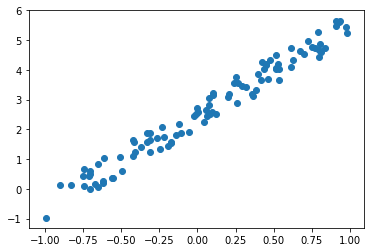

In [0]:
n=100
x = torch.ones(n,2) # 100x2 tensor/vector/array
x[:,0].uniform_(-1.,1) # all rows, first column create values between -1 and 1
# x[:5]
a = tensor(3.,2)
y = x@a + torch.rand(n)
plt.scatter(x[:,0], y); # plot the equation with the first column of x

**The steps we will take**

1. Try drawing a line (ie. compute prediction called `y_hat`)

2. Calculate `loss` (in this case mse makes sense but we can use any loss function). The differents between the predition and the actual values of y.

3. Calculate the derivative of the loss (called gradient). PyTorch calculates the derivative for you using `.backward` and stores the result in an attribute called `.grad`

4. Update the coefficients a and b


In [0]:
# Define loss function given prediction and actual
def mse(y_hat, y): return ((y_hat-y)**2).mean()

tensor(7.9185)


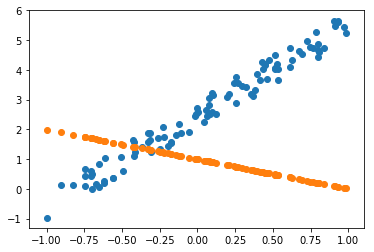

In [0]:
# Lets guess that a is -1, 1
a = tensor(-1.,1) # then we can compute a prediction
y_hat = x@a # compute prediction
loss = mse(y_hat, y) # calculate our error and plot it
print(loss)
plt.scatter(x[:,0],y) # original points
plt.scatter(x[:,0],y_hat) # prediction

tensor(0.3291)


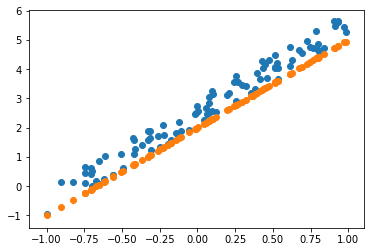

In [0]:
# Lets try a different guess; lets guess a is 3, 2
a = tensor(3.,2.)
y_hat = x@a # compute prediction
loss = mse(y_hat, y) # calculate our error and plot it
print(loss)
plt.scatter(x[:,0],y) # original points
plt.scatter(x[:,0],y_hat) # prediction

So we can see we will get less loss if we fit a line closer to our points.

Now let's do it iteratively with PyTorch.

In [0]:
a = nn.Parameter(a); a # start with some parameter a (default -1, 1)

Parameter containing:
tensor([3., 2.], requires_grad=True)

In [0]:
def update():
    y_hat = x@a # compute prediction
    loss = mse(y, y_hat) # compute error
    
    if t % 10 == 0: print(loss) # defined later (print loss every now and again)

    # compute the gradient or slope or dloss/dx for every param x
    # this will tell you which way is DOWN TO LOWER LOSS
    loss.backward() # this just gets us the slope (ie. the params)

    with torch.no_grad(): # turn grad calcs off when you do the SGD update
        # note: lr is just what we multiply by the gradient (step size)
        a.sub_(lr * a.grad) # update a (subtract coefficients from gradient in place)
        a.grad.zero_() #zero out the gradients so we can restart

In [0]:
lr = 1e-1
for t in range(100): update()

tensor(0.3291, grad_fn=<MeanBackward0>)
tensor(0.0881, grad_fn=<MeanBackward0>)
tensor(0.0853, grad_fn=<MeanBackward0>)
tensor(0.0853, grad_fn=<MeanBackward0>)
tensor(0.0853, grad_fn=<MeanBackward0>)
tensor(0.0853, grad_fn=<MeanBackward0>)
tensor(0.0853, grad_fn=<MeanBackward0>)
tensor(0.0853, grad_fn=<MeanBackward0>)
tensor(0.0853, grad_fn=<MeanBackward0>)
tensor(0.0853, grad_fn=<MeanBackward0>)


## Deep Dive: Natural Language Processing (NLP) (fastai.text)

NLP will help us add to our understanding of deep learning by showing us a slightly modified architicture that happens to be really good at solving language problems (or more generally sequential problems).

> **Objectives:**

**Case Study:** Classify movie reviews as positive or negative from IMDB.

**Method:** Use the pretrained language model (Wikitext103) then we will train a IMBd language model then classify the text as positive or negative.

#### Step 1: Create TextClassificationDataBunch

#### Step 2: Tokenization and Numericalization

TextClassificationDataBunch
Tokenization
Numericalization

**Additional Notes**

* If you are doing NLP on Kaggle use all of the text (train and test) to train your model. The only thing you can't use are the labels.

* Recurrent Neural Network


## Deep Dive: Tabular Data (fastai.tabular)

If you have things in a spreadsheet or relational database, etc. you can use NN to analyze tabular data

Example:
Like sales forecasting, product failure prediction, pricing, credit risk, resume screening, store location optimization, etc



## Deep Dive: Collaborative Filtering (fastai.collab)

**Definition:** 
- one model

Case Study: Movie Predictions; Customer Purchase Prediction

Will user 49 like movie 103?

Method:
Create two random matricies (one for each movie and users) and use gradient descent to make the products of the matricies give you a prediction close to what people rate the movies as.


UserID, MovieID, Rating?

URLs.ML_SAMPLE: MovieLens dataset

Make predictions based on other peoples preferences

Problems:

* **Cold Start Problem:** The time you particularly care about recomending good movies is when you have a new user and thats also the time when you have no data ; Solution: metadata driven model or ask people using the UX...

* blablabla









## Deep Dive: Foundations of Neural Networks

# Vocabulary and Reference Materials

**Universal Approximation Theorem:** An awesome mathematical property arises when you combine matrix multiplication and relus in which you can solve any arbitrarily complex mathematical function to any arbitrarily high level of accuracy (assuming you can train the params in terms of time, data availability, etc).

**Backpropagation:** The algorithm used to update parameters/weights in a network. In the simple case of SGD its the part where we update our parameter/weights guess (params -= params.grad * lr).

**Discriminative Learning Rates:** Differential learning rates across layers of a neural net. Particularly useful when using trainsfer learning because we may want to train the earlier layers slower than the later ones.

**Accelerated SGD:** The use of momentum and other optimizaton techniques to do SGD faster.

**Latent Factors/Features:** Things that suddenly appear when training. For example if you have a RNN language model and female appears near nurse and male  appears near doctor. They are basically relevant 'aggregates' of observered features.

**Embedding:** A computational shortcut...an array lookup that is mathematically identical to matrix multiply by a 1-hot encoded matrix. `n_factors = 40` (this is the width of the embedding matrix?) 

Eg. take a 2D matrix rep of bla and you can start to see interesting things. "The embedding projection discovered geography"

**Regularization:** A technique used to keep models from overfitting. There are lots of methods of doing this for example with momentum, weight decay, etc. A way to penalize the loss function and therefore simplify the model.

**Weight Decay:** A type of regularization in which we penalize complexity so that our algorithm generalizes better. Take a loss function and take the sum^2 of the errors times the wd (a very small number) and this will penalize complexity.

Note: WD of .1 typically works well but fastai folks have been very conservative with it and .01 is the default.

**Optimizers:** PyTorch optimizers allow you to optimize a learner by using things like momentum, weight decay, etc. One common optimizer is Adam. 

**Adaptive Moment Estimation (Adam):** An optimization technique for gradient descent that uses momentum + rms prop to jump around more efficiently to get to convergence. Its basically a way of having a dynamic learning rate.

`optim.Adam(...)`

Note: learner is just doing this for you

**Momentum:** A term that is added to the update function to help optimize the speed of convergence.

In fastai, .9 is really common and tends to work well.

Learning rate vs momentum graph: when lr is low mom is higher (that combination is called fit_one_cycle).

**Principle Component Analysis:** A technique for dimentionality reduction (reducing the number of columns).

Taking layers of neural nets and chucking them through PCA is VERY OFTEN a good idea because often we have way more activations than we really need.

Eg. Image Similarity -> use PCA

**Dropout:** A regularization technique to keep NNs from overfitting. Takes a std fully connected nw then at random it throws away some activations and the things connected to it. We throw each away with a probability P then put them back and throw away some other ones.

`ps=X #the probability for each dropout`

Note: Special dropout on the embedding layer is sometimes used because ????

**Batch Normalization:** A regularization technique

**Data Augmentation:** Another type of regularization which helps you generalize and costs you nothing. 

**Convolutions:** A specific type of multiplication in which you multiply things by a kernal (martix) to get an output. It finds edges and gradients

Stride2 convolution - skipping every alternate input pixel

setosa.io/ev/image-kernals

**Resblocks and Skip Connections:** Using skip connections

TODO READ: Visualizing Loss Landscape of Neural Nets

`SequentialEx`

`MergeLayer`

**Dense Net/Dense Block:** Resnet with concat instead of + like in res...things get big quick; memory intensive but for small datasets they can be really really great.

**Data Ethics:** We can generate realistic looking text, video and audio now so we need to speak about ethics.

Imagenet is over half America and Great Brittian so there is a LOT of bias in the people that are creating it.

Russell Brandom
Ali Winston
Jacon Snow

**U-net Architecture:** Conv Networks for Biomedical Image Segmentation

Down-sampling path (encoder)
Up-sampling path (decoder)

Lets us do a conv that lets us end up with somethign that is 2x the size:
* Nearest Neighbor Interpolation - aaa
* Bilinear Interpolation - bbb
* Pixel Shuffling (fastai) - Subpixel convolutions

Cross Connections

Skip Links

Summary: Identity connections (+ or concat style) are really useful

**Generative Adversarial Network (GAN):** Uses a loss function that calls another model

Generator ()
Discriminator/Critic (is this a hi-res or generated pic)

----

How can we represent concepts? Eg. reverse engineering, shiny, etc

 

In [0]:
learn.summary() # print output shape of every layer
learn.model # show the model

# manual convolutions
# TODO

# Heatmap
how_heatmap(avg_acts)
# m[0] will be the convolutional part of the model


Here is what we've learned so far

Affine functions and non-linearities

Parameters and activations

Random init and transfer learning

SGD; Momentum; Adam

Convolutions

Batch-norm

Droupout

Data augmentation

Weight decay

Res/dense blocks

Image Classification and regression

Embeddings

Continuous and categorical variables

Collaboratice filtering

Language models; NLP classification

Segmentation; U-net-GANs

RNNs; stacked RNN
* great for sequence labeling tasks